# Demo

The `mfanalysis` package allows us to perform fractal and multifractal analysis of signals

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
sns.set(style="darkgrid")

## Generating a signal

Let's first generate a brownian motion (fractional brownian motion with H=0.5)

In [38]:
from mfanalysis.generate_data import generate_fbm_path

In [81]:
X = generate_fbm_path(4096, 0.8)[:, 0]

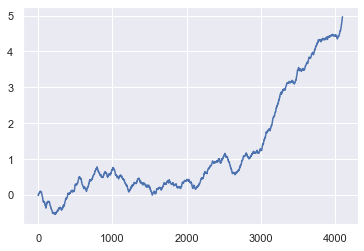

In [82]:
plt.plot(X)
plt.show()

## Second order analysis

Second order analysis is done with the `psd` module

The sampling frequency `fs` is necessary in order to correctly label the frequency axis

In [43]:
import mfanalysis.psd as psd

In [74]:
fs = 1

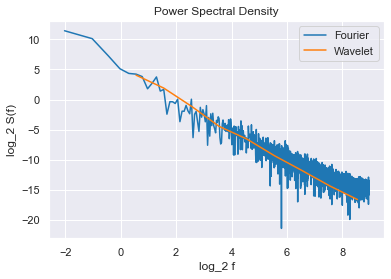

In [49]:
psd.plot_psd(X, fs, n_moments=2)

The Fourier-based PSD estimation is done using the Welch estimator.

The arguments relative the Fourier-based estimation are:
* `n_fft`: length of the FFT used
* `seg_size`: size of the segment used in the Welch estimation

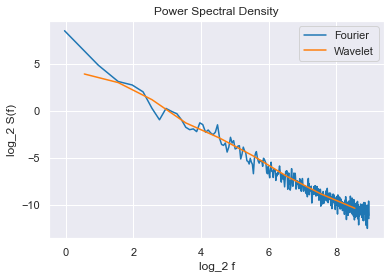

In [12]:
psd.plot_psd(X, fs, n_fft=1024)

The Wavelet-based estimation is done using wavelet analysis based on the Daubechies wavelet.

The number of vanishing moments can be controlled using the `n_moments` argument

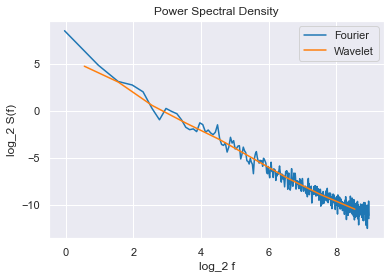

In [13]:
psd.plot_psd(X, fs, n_moments=3, n_fft=1024)

The wavelet-based estimation of the PSD is obtained via the `wavelet_estimation` function

In [14]:
PSD = psd.wavelet_estimation(X, fs, n_moments=3)

The output is an instance of the `PSD` namedtuple, with two fields: `freq` which contains the frequency support of the PSD estimation, and `psd` which contains the actual power estimates

In [15]:
PSD.freq, PSD.psd

(array([375.        , 187.5       ,  93.75      ,  46.875     ,
         23.4375    ,  11.71875   ,   5.859375  ,   2.9296875 ,
          1.46484375]),
 array([7.09212353e-04, 2.05468679e-03, 7.08639659e-03, 2.94548635e-02,
        1.20995503e-01, 4.10319644e-01, 1.51252188e+00, 8.47994221e+00,
        2.71647266e+01]))

## Estimating beta

Our model for the power density spectrum is as follows:

$$ \Gamma(\nu) = C \left| \nu \right| ^ {\beta}$$

Using the log-log plot we can then easily estimate $beta$ by performing a linear regression over the wavelet PSD estimate

In [16]:
import mfanalysis.fractal_analysis as fa

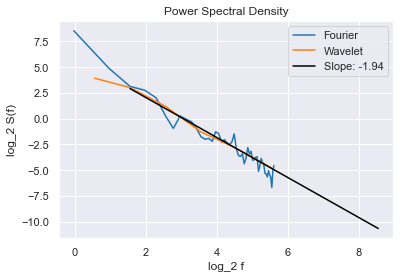

In [17]:
fa.plot_fractal(X, fs, freq_band=(2, 512), n_fft=1024)

The `freq_band` parameter controls the frequency support for the $\beta$ estimation

The `log` parameter allows us to control the log function used, which changes the axes values but not the plotted curves. Available values are contained in the `psd.log_function` dictionary

In [18]:
[*psd.log_function]

['log2', 'log']

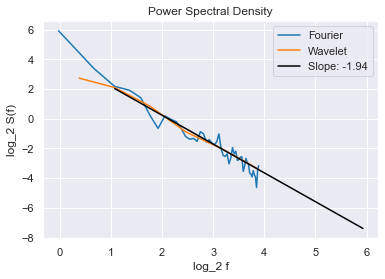

In [19]:
fa.plot_fractal(X, fs, freq_band=(2, 512), n_fft=1024, log='log')

The estimates of $\beta$ and $\log(C)$ can be directly obtained from the signal using the `fractal_analysis` function

In [20]:
fractal = fa.fractal_analysis(X, fs, n_moments=2, freq_band=(2, 512))

The output is an instance of the FractalValues namedtuple, which contains 3 fields:

- `beta`: the estimated 1/f slope
- `log_C`: the logged value of the 1/f intercept
- `freq`: the frequency support for the estimation

In [21]:
fractal

FractalValues(beta=-1.9399656286611124, log_C=5.93211830445758, freq=array([[8.55074679],
       [7.55074679],
       [6.55074679],
       [5.55074679],
       [4.55074679],
       [3.55074679],
       [2.55074679],
       [1.55074679]]))

## Wavelet Transform

Wavelet transform is performed in the package using the `wavelet` submodule

In [22]:
from mfanalysis.wavelet import wavelet_analysis

TODO: detail the wavelet transform

In [23]:
WT = wavelet_analysis(X)

/home/dumeur/Multifracs/mfanalysis/mfanalysis/wavelet.py:100: UserWarning: Value of j2 is higher than the maximum allowed level. Max level and j2 set to 9
  f"Max level and j2 set to {max_level}", UserWarning)


The output is a namedtuple with 3 fields:

* `wt_leaders`: The wavelet leaders if computed
* `wt_coefs`: Wavelet coefficients
* `j2_eff`: Maximum scale that the coefficients were effectively computed for

## Multifractal Analysis

Multifractal analysis is done using the `mf_analysis` submodule

In [50]:
import mfanalysis.mf_analysis as mf

In [51]:
import numpy as np

Basic parameters are:

`j1` and `j2`, which indicate respectively the minimum and the maximum scale to consider when fitting wavelet coefficients

`q` The values of q for which the wavelet coefficients will be estimated

`n_cumul` The maximum order of the cumulants to compute

In [83]:
sf, cumul, mfs = mf.mf_analysis_full(X,
    j1=2, j2=8,
    q=np.arange(-2,3),
    n_cumul=2,
)

In [63]:
sf.j

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [59]:
sf.q

array([-2, -1,  0,  1,  2])

In [58]:
sf.values

array([[1.93596463e+09, 1.92802698e+08, 4.10150364e+09, 2.94040937e+06,
        1.18501864e+05, 2.92375004e+05, 2.18546888e+04, 1.91074703e+05,
        1.54958454e+02],
       [3.12751277e+03, 1.66843295e+03, 4.05413714e+03, 4.78155094e+02,
        1.81128055e+02, 2.26387656e+02, 6.89683733e+01, 1.60982029e+02,
        1.11653913e+01],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00],
       [1.66359981e-03, 2.55328540e-03, 4.22381290e-03, 7.34997827e-03,
        1.31603344e-02, 1.97930969e-02, 4.23622259e-02, 5.50635622e-02,
        1.13604316e-01],
       [4.26263501e-06, 9.99785699e-06, 2.79695818e-05, 8.45985147e-05,
        2.71047112e-04, 6.92605927e-04, 2.78644584e-03, 5.05743677e-03,
        1.54097321e-02]])

In [64]:
sf.mrq.name

'wavelet_coeffs'

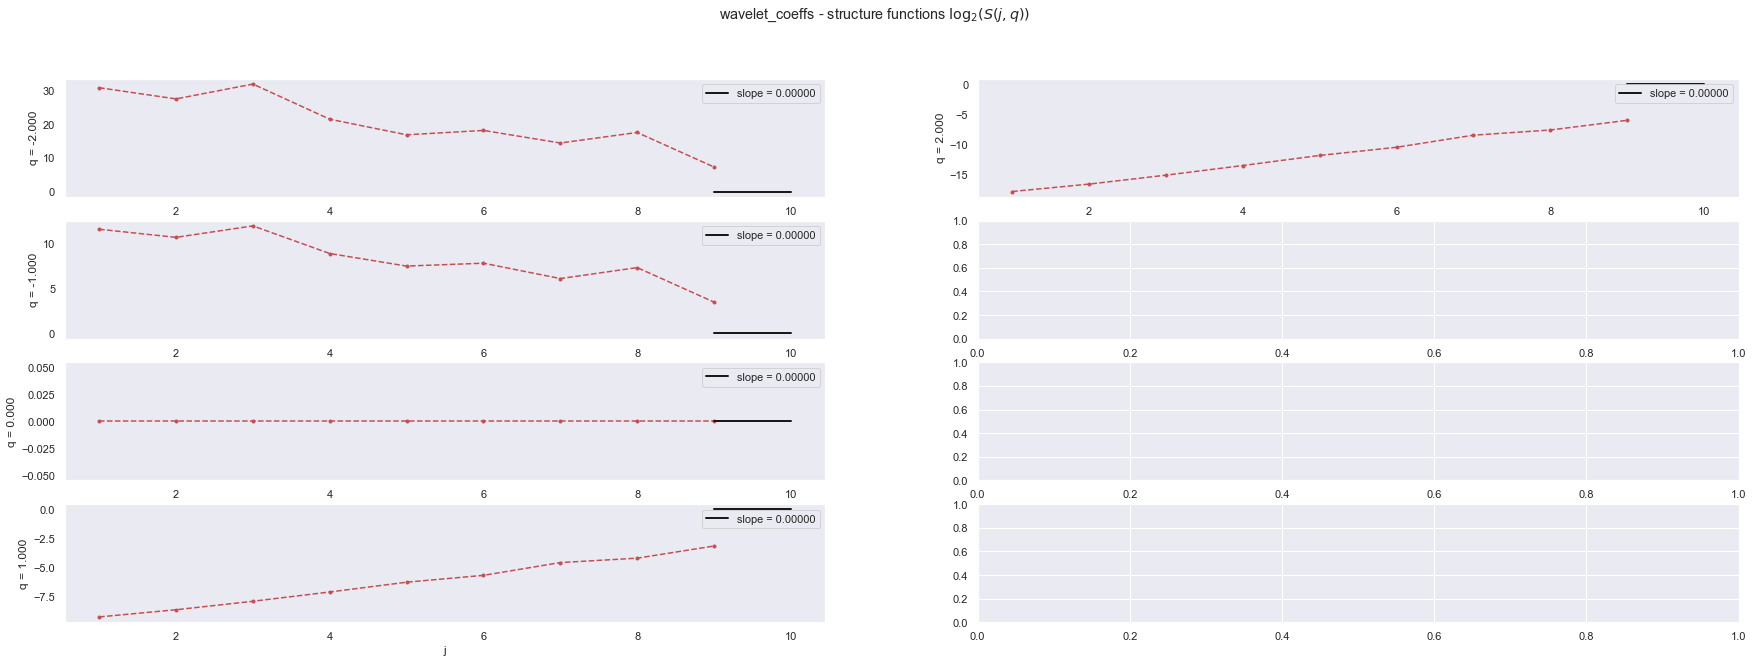

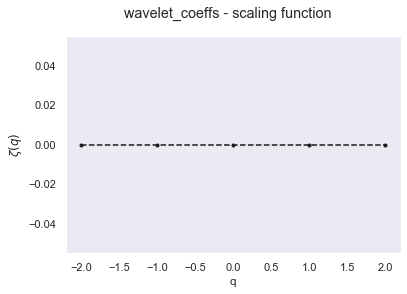

In [53]:
sf.plot()

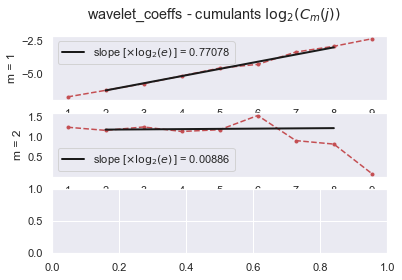

In [84]:
cumul.plot()

In [85]:
cumul.log_cumulants

array([0.770778  , 0.00885833])

In [29]:
mfs

## Object oriented approach

The `Signal` dataclass offers an approach where the signal data and any intermediary results and parameters are kept in an instance

In [30]:
import mfanalysis.signal as sig

In [31]:
S = sig.Signal(X, fs, 'log')

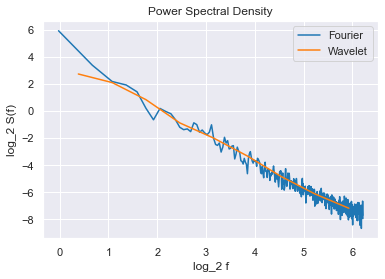

In [32]:
S.plot_psd(n_fft=1024)

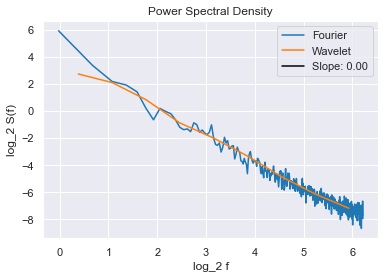

In [33]:
S.plot_fractal(n_fft=1024)

In [34]:
S.fractal_analysis()

FractalValues(beta=0.0, log_C=2.7278859136448665, freq=array([[0.38174858]]))

In [35]:
S.wt_psd

PSD(freq=array([375.        , 187.5       ,  93.75      ,  46.875     ,
        23.4375    ,  11.71875   ,   5.859375  ,   2.9296875 ,
         1.46484375]), psd=array([7.60649149e-04, 2.17677545e-03, 7.88713832e-03, 3.58645679e-02,
       1.35100861e-01, 4.13732149e-01, 2.29852039e+00, 8.12751392e+00,
       1.53005062e+01]))

In [36]:
S.welch_psd

PSD(freq=array([  0.       ,   0.9765625,   1.953125 ,   2.9296875,   3.90625  ,
         4.8828125,   5.859375 ,   6.8359375,   7.8125   ,   8.7890625,
         9.765625 ,  10.7421875,  11.71875  ,  12.6953125,  13.671875 ,
        14.6484375,  15.625    ,  16.6015625,  17.578125 ,  18.5546875,
        19.53125  ,  20.5078125,  21.484375 ,  22.4609375,  23.4375   ,
        24.4140625,  25.390625 ,  26.3671875,  27.34375  ,  28.3203125,
        29.296875 ,  30.2734375,  31.25     ,  32.2265625,  33.203125 ,
        34.1796875,  35.15625  ,  36.1328125,  37.109375 ,  38.0859375,
        39.0625   ,  40.0390625,  41.015625 ,  41.9921875,  42.96875  ,
        43.9453125,  44.921875 ,  45.8984375,  46.875    ,  47.8515625,
        48.828125 ,  49.8046875,  50.78125  ,  51.7578125,  52.734375 ,
        53.7109375,  54.6875   ,  55.6640625,  56.640625 ,  57.6171875,
        58.59375  ,  59.5703125,  60.546875 ,  61.5234375,  62.5      ,
        63.4765625,  64.453125 ,  65.4296875,  66.40625

In [37]:
S.fractal

FractalValues(beta=0.0, log_C=2.7278859136448665, freq=array([[0.38174858]]))